# Imports and setups

In [1]:
%matplotlib inline

import os
import tarfile
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zlib import crc32
from pathlib import Path
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score 

# Global parameters

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
DATASET_PATH = Path("..", "Datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

TEST_RATIO = 0.2

# Functions

In [3]:
# ====== DOWNLOAD AND EXTRACT THE DATASET ====== #
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=DATASET_PATH):
    # === Creating the destination directory if necessary
    os.makedirs(housing_path, exist_ok=True)
    # === Creating the destination file path
    tgz_path = Path(housing_path, "housing.tgz")
    # === Requesting (downloading) the data 
    urllib.request.urlretrieve(housing_url, tgz_path)
    # === Open downloaded file
    housing_tgz = tarfile.open(tgz_path)
    # === Extract the csv, since we downloaded a compressed .tar.gz 
    housing_tgz.extractall(path=str(housing_path))
    # === Close the compressed file
    housing_tgz.close()

# ====== LOAD CSV TO MEMORY ====== #
def load_housing_data(housing_path=DATASET_PATH):
    csv_path = Path(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# ====== SPLIT THE DATA INTO TRAIN AND TEST SETS ====== #
def split_train_test(data, test_ratio=0.2):
    # === Create a random index array with no repetitions
    shuffled_indices = np.random.permutation(len(data))
    # === Find the amount of data on the test_set
    test_set_size = int(len(data) * test_ratio)
    # === Test indices = get indices from 0 to test_set_size-1
    test_indices = shuffled_indices[:test_set_size]
    # === Train indices = all indices from test_set_size till the end of the array
    train_indices = shuffled_indices[test_set_size:]
    # === Use the selected indexes to split and return the data
    return data.iloc[train_indices], data.iloc[test_indices]

# ====== METHOD TO DECIDE IF DATA IS ON THE TEST OR TRAINING SET ====== # 
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

# ====== SPLIT THE DATA INTO TRAIN AND TEST SETS CONSISTENTLY ====== #
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


# Loading the data

In [4]:
fetch_housing_data()
data = load_housing_data()

# Understanding the data

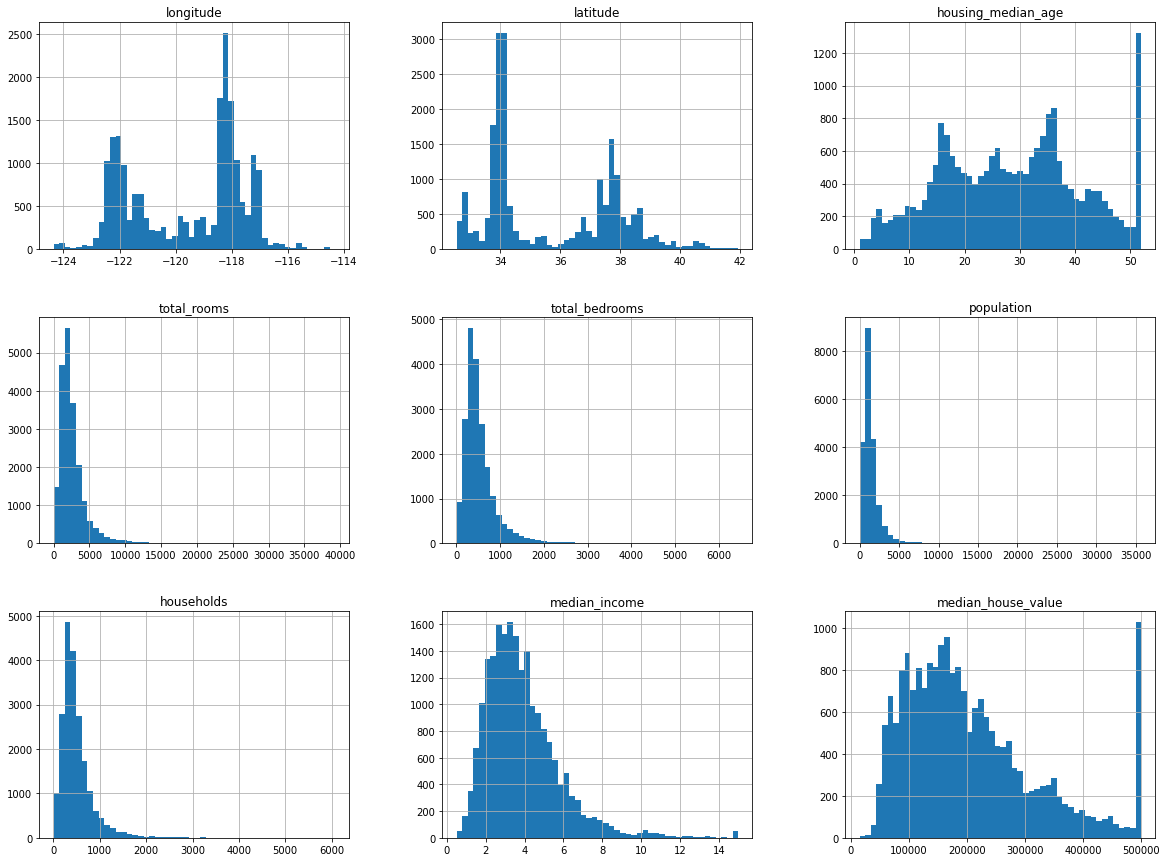

In [5]:
# ====== Uncomment one to check the output, or use the print function (but jupyter won't format the result as well)
# === Checkig some rows
# data.head()
# === Table structure (Columns, data types, Non-Null count)
# data.info()
# === useful statistics for each column
# data.describe()
# === Getting unique values for a column and count quantities for each one
# data["ocean_proximity"].value_counts()
# === Plotting histograms
data.hist(bins=50, figsize=(20,15)); plt.show()


# Splitting the sets

## Random split strategy

In [6]:
# === Common split (would change every time you reload the data or add new data)
# train_set, test_set = split_train_test(data, test_ratio=TEST_RATIO)
# === Split by hashing the id
data_with_id = data.reset_index() # To create an index column
train_set, test_set = split_train_test_by_id(data_with_id, TEST_RATIO, "index")
# === Making sure everything is right
print(f"Train set: {len(train_set)}\nTest set: {len(test_set)}\nRatio = {len(test_set)/len(train_set)}")

Train set: 16512
Test set: 4128
Ratio = 0.25


## Stratifying and splitting strategy

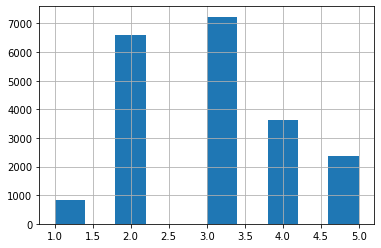

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64


In [7]:
# === Creating sub-groups (strats) for the median income
data["income_cat"] = pd.cut(data["median_income"],
                            bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
                            labels=[1,2,3,4,5])
# === Verifying the result
data["income_cat"].hist()
plt.show()

# === Spliting
split = StratifiedShuffleSplit(n_splits=1, test_size=TEST_RATIO, random_state=42) # no particular reason for the use of 42
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

# Verifying the results
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

## Comparing the strategies 

In [8]:
# === Counting the classes (1 to 5) on the original dataset
overall_count = pd.cut( data["median_income"], 
                        bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                        labels=[1,2,3,4,5]
                ).value_counts().sort_index()
overall_count /= overall_count.sum()

# === Counting the classes (1 to 5) on the stratified test set
stratified_result = strat_test_set["income_cat"].value_counts().sort_index()
stratified_result /= stratified_result.sum()

# === Counting the classes (1 to 5) on the randomly generated test set
random_result = pd.cut( test_set["median_income"], 
                        bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                        labels=[1,2,3,4,5]
                ).value_counts().sort_index()
random_result /= random_result.sum()

# === Calculating the stratified set error for each class
strat_error = (stratified_result - overall_count) / overall_count * 100
# === Calculating the random set error for each class
rand_error = (random_result - overall_count) / overall_count * 100

# === Merging the information to display
final_result = pd.concat([overall_count, stratified_result, random_result, rand_error, strat_error], axis=1)
final_result.columns = ["Overall", "Stratified", "Random", "Rand. %error", "Strat. %error"]

final_result


,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.033672,-15.450122,-0.243309
2,0.318847,0.318798,0.330669,3.707643,-0.015195
3,0.350581,0.350533,0.347141,-0.981205,-0.013820
4,0.176308,0.176357,0.168605,-4.369332,0.027480
5,0.114438,0.114583,0.119913,4.784081,0.127011


In [9]:
# === Removing strafied column so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True) 

# Visualizing and Gaining insights

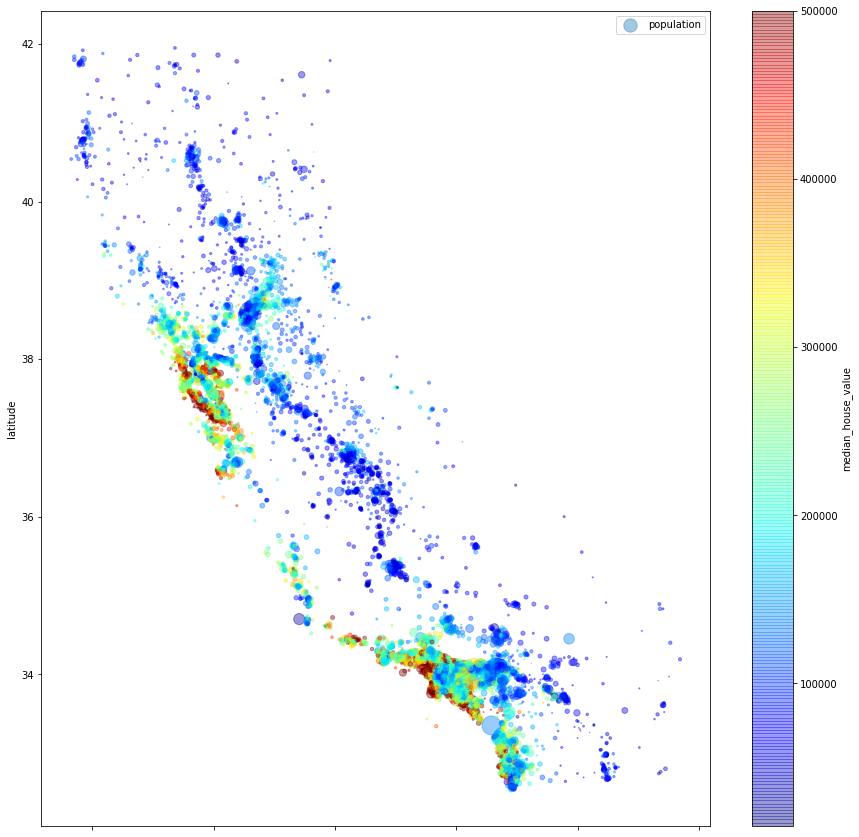

In [10]:
# === Making a test copy for the training set
exploration_data = strat_train_set.copy()

# === Plotting lat vs lon
exploration_data.plot(kind="scatter",                       # Type of plot 
                      x="longitude", y="latitude",          # Map axis to dataframe columns
                      alpha=0.4,                            # Since there are too many points, make each one very transparent (helps to see density)
                      figsize=(15,15),                      # Make the figure bigger
                      s=exploration_data["population"]/100, # Play with the dots radius to make so more population = bigger dots
                      c="median_house_value",               # Play with colors to allow us to see pricing on the plot
                      cmap=plt.get_cmap("jet"),             # 'c' will make grayscale coloring, so we change the color map to jet (from blue to red)
                      colorbar=True,                        # Show colorbar legend
                      label="population"                    # Set label to population to make a legend
                    )
plt.legend()


# Looking for Correlations

In [11]:
# === Calculating a matrix with Pearson's correlation for each pair of attributes
corr_matrix = data.corr()

# === Verifying the correlations with the median_house_value
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

__Pearson's correlation ranges from [-1, 1]__

* Correlations > 0 means "when one increase, the other tends to increase";
* Correlations < 0 means "when one increase, the other tends to decrease";
* Correlations = 0 means there is no __linear__ relation between the two;

### Scatter Plotting + histogram of all the column combinations using pandas scatter_matrix

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

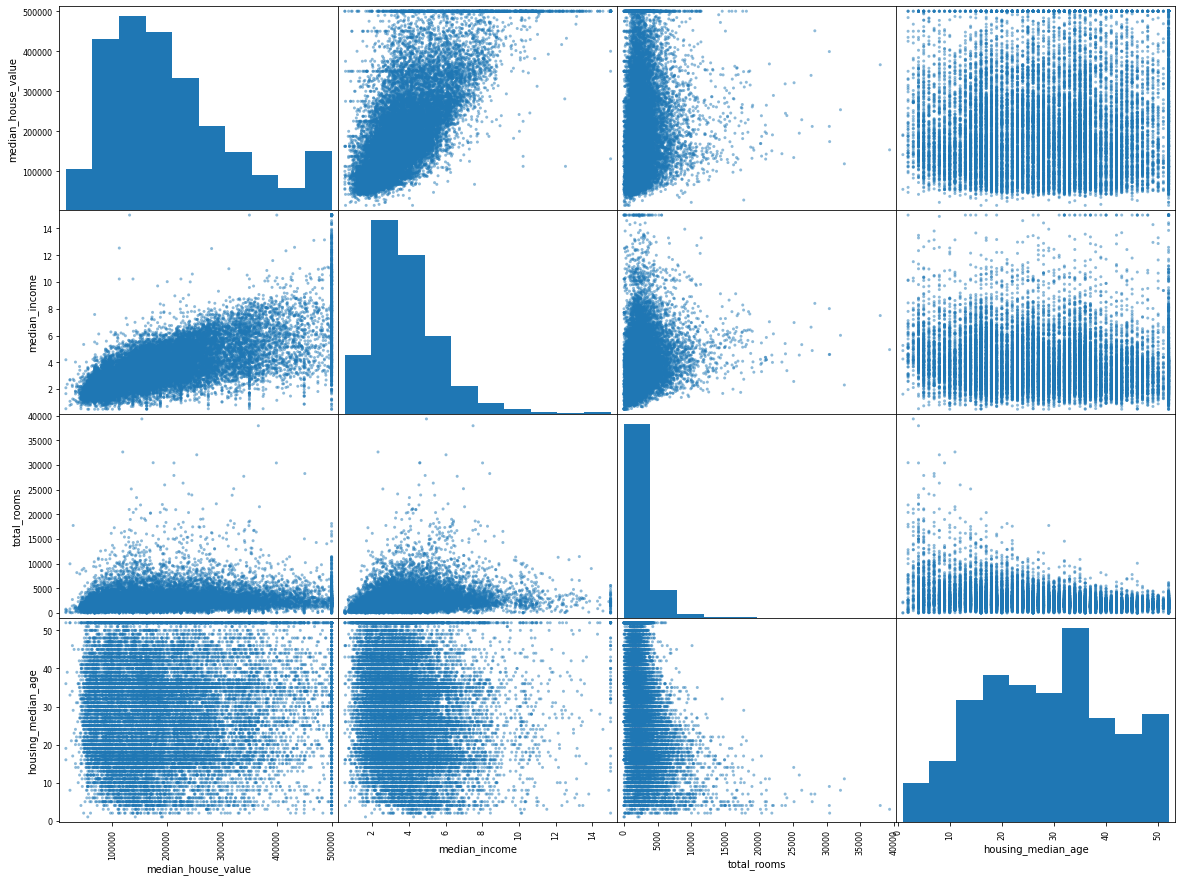

In [12]:
# === Since our table has 11 columns and 11^2 = 121, we can filter only 4 columns so the visualization is more manageable
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
# === Plot all variables versus each other using pandas scatter_matrix
pd.plotting.scatter_matrix(data[attributes], figsize=(20,15))


median_house_value vs median_income seems promising, let's zoom in

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

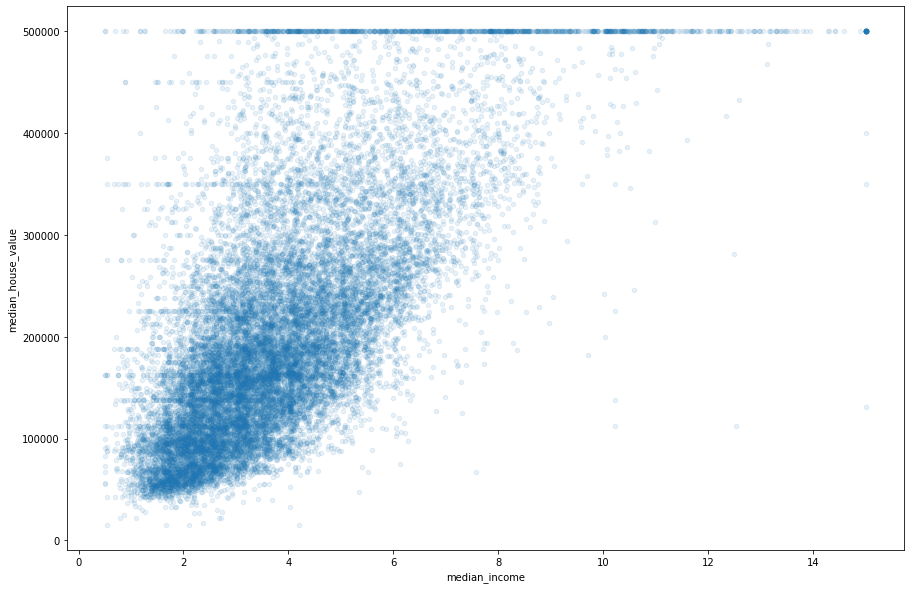

In [13]:
data.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(15,10))

Trying some diferent combinations

In [14]:
# === Creating some new columns based on correlations between existing columns
data["rooms_per_household"] = data["total_rooms"]/data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"]/data["total_rooms"]
data["population_per_household"] = data["population"]/data["households"]

# === Checking correlation matrix with the new values 
corr_matrix = data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

# Prepare the data for machine learning algorithms

In [15]:
data = strat_train_set.drop("median_house_value", axis=1)
data_labels = strat_train_set["median_house_value"].copy()

# Data cleaning

## Missing values - Pandas

In [16]:
# Option 1 - Drop the rows missing any values
data.dropna(subset=["total_bedrooms"])
# Option 2 - Drop the entire column that has missing values
data.drop("total_bedrooms", axis=1)
# Option 3 - Fill the missing values with the mean, median, zeros ...
median = data["total_bedrooms"].median()
data["total_bedrooms"].fillna(median, inplace=True) # filling with the median

## Missing values - scikit learn

In [17]:
# Create a object that will fill the missing values by some strategy
imputer = SimpleImputer(strategy="median")
# Dropping non numerical columns, because the method doesn't work on that
data_num = data.drop("ocean_proximity", axis=1)
# Compute the value that will fill the missing rows for each column and storing on its statistics_ attribute
imputer.fit(data_num)
print("Imputer statistics: ", imputer.statistics_)
print("Data medians:       ", data_num.median().values)

X = imputer.transform(data_num)
data_tr = pd.DataFrame(X, columns=data_num.columns, index=data_num.index)

Imputer statistics:  [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
Data medians:        [-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


# Handling text and Categorical Attributes 

In [18]:
# === Isolating the ocean proximity column
data_cat = data[["ocean_proximity"]] # The double brackets makes so the result is a dataframe
print(data_cat.head(10))
# ====== ENCODING THE TEXT ====== #
# === As sequential numerical values
print("====== SEQUENTIAL NUMERICAL ENCODING ======")
ordinal_encoder = OrdinalEncoder()
data_cat_encoded = ordinal_encoder.fit_transform(data_cat)
print(data_cat_encoded[:10])
print(ordinal_encoder.categories_)
# === One-Hot encoding
# each textual class is represented by a 1 in an array with every possible class
print("====== ONE-HOT ENCODING ======")
cat_encoder = OneHotEncoder()
data_cat_1hot = cat_encoder.fit_transform(data_cat)
print(data_cat_1hot.toarray())
print(cat_encoder.categories_)


      ocean_proximity
17606       <1H OCEAN
18632       <1H OCEAN
14650      NEAR OCEAN
3230           INLAND
3555        <1H OCEAN
19480          INLAND
8879        <1H OCEAN
13685          INLAND
4937        <1H OCEAN
4861        <1H OCEAN
====== SEQUENTIAL NUMERICAL ENCODING ======
[[0.]
 [0.]
 [4.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
====== ONE-HOT ENCODING ======
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


## Custom Transformers

In [19]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True) -> None: # no *args or **kwargs
        # One hyperparameter: add_bedrooms_per_room (True or False)
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # Nothing else to do
    def transform(self, X) -> None:
        # Get all rows from the rooms_ix column and divide it by all rows on households_ix column
        # do it row by row (or index by index since we transformed the column into a np.array)
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        # Repeat for population_ix and households_ix
        population_per_household = X[:, population_ix] / X[:, households_ix]
        # Repeat for bedrooms and rooms if user asked for it
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            # Transpose the arrays to columns and concatenate each column
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            # Transpose the arrays to columns and concatenate each column
            return np.c_[X, rooms_per_household, population_per_household]
    
# === Creating the object
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
data_extra_attribs = attr_adder.transform(data.values)
# Displaying the resultant data in a dataframe format to ease understanding
pd.DataFrame(data_extra_attribs, columns=np.concatenate((data.columns.values, ["rooms/household", "population/household"]), axis=0), index=data.index)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms/household,population/household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785
...,...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.2,46,1271,236,573,210,4.9312,INLAND,6.05238,2.72857
12053,-117.56,33.88,40,1196,294,1052,258,2.0682,INLAND,4.63566,4.07752
13908,-116.4,34.09,9,4855,872,2098,765,3.2723,INLAND,6.34641,2.74248
11159,-118.01,33.82,31,1960,380,1356,356,4.0625,<1H OCEAN,5.50562,3.80899


## Transformation Pipelines

In [20]:
# ====== PIPELINE FOR NUMERICAL DATA ONLY ====== #
num_pipeline = Pipeline([
#   (hyperparam name,  HyperparamFunction)
    ('imputer',         SimpleImputer(strategy="median")),  # Must have a fit_transform method
    ('attribs_adder',   CombinedAttributesAdder()),         # Must have a fit_transform method
    ('std_scaler',      StandardScaler()),                  # Must have a fit method (fit_transform not obligatory)
])

data_num_tr = num_pipeline.fit_transform(data_num)

# ====== PIPELINE FOR TEXT AND NUMERIC DATA ====== #
num_attribs = list(data_num) # numerical attributes
cat_attribs = ["ocean_proximity"] # categorical attributes
full_pipeline = ColumnTransformer([
#   (NAME, TRANSFORMER, LIST OF COLUMNS),
    ("num", num_pipeline, num_attribs), # 'num' is a step of our pipeline, that applies the num_pipeline on the columns num_attribs
    ("cat", OneHotEncoder(), cat_attribs), # 'cat' is a step of our pipeline, that applies the OneHotEncoder on the columns num_attribs
])
# transforming all the data
data_prepared = full_pipeline.fit_transform(data)

# Select and Train a Model

## _LINEAR MODEL_

In [21]:
# ====== CREATING THE MODEL ====== #
lin_reg = LinearRegression()

# ====== TRAINING ====== #
lin_reg.fit(data_prepared, data_labels)


# ====== EVALUATING ====== #
# === Manually
some_data_prepared = data_prepared[:5] # First 5 rows
some_labels = data_labels[:5] # First 5 labels
print("Predictions: ", lin_reg.predict(some_data_prepared)) # Predicting
print("Labels: ", list(some_labels)) # Checking the ground truth
# === Metrics
# RMSE
data_predictions = lin_reg.predict(data_prepared)
lin_mse = mean_squared_error(data_labels, data_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


68628.19819848922

## _DECISION TREE REGRESSOR_ 

In [22]:
# ====== CREATING THE MODEL ====== #
tree_reg = DecisionTreeRegressor()

# ====== TRAINING ====== #
tree_reg.fit(data_prepared, data_labels)

# ====== EVALUATING ====== #
data_predictions = tree_reg.predict(data_prepared)
tree_mse = mean_squared_error(data_labels, data_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse


0.0

## Error 0? But in the training set, so this could just be overfitting... So we can try it with cross validation to verify if it is really 0% error!

### __NOTE:__ SKLearn cross-validation method expects a utility function (+ is better), not a cost function (- is better)

In [23]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

# K folds splits the set into K subsets, each time a diferent fold is used for validation while the rest is used for training. 
# This means that the network must be trained K times
scores = cross_val_score(
    tree_reg, # MODEL TO BE EVALUATED
    data_prepared, # ENTIRE DATASET
    data_labels, # THE RESPECTIVE LABELS
    scoring="neg_mean_squared_error", # ERROR METRIC THAT WILL BE RETURNED
    cv=10 # NUMBER OF FOLDS
    )

tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)


Scores:  [67961.10987087 66326.67531085 71781.27076403 67422.77561769
 71580.71977772 75412.60292304 71098.76505028 70603.85243284
 76067.81406063 69301.51692436]
Mean:  70755.7102732324
Standard deviation:  3040.1896652570513


## Mean of 71,355 +- 2,912... That looks worst then the linear model... Maybe we can try the kfold strategy for the linear model.

In [24]:
lin_scores = cross_val_score(
    lin_reg,
    data_prepared,
    data_labels,
    scoring="neg_mean_squared_error",
    cv=10
)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.674001798348


### Mean of 69,052 +-2,731... It's oficial, the linear model performs better... So we can say that the decision tree is overfitting the training data so badly that it becomes worst then the linear model.

### So let's try yet another model.


## _Random Forest Regressor_

In [25]:
# ====== CREATING THE MODEL ====== #
forest_reg = RandomForestRegressor()

# ====== TRAINING ====== #
forest_reg.fit(data_prepared, data_labels)

# ====== EVALUATING ====== #
# === Single training
data_predictions = forest_reg.predict(data_prepared)
forest_mse = mean_squared_error(data_labels, data_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Score (only training): ", forest_rmse)
# === KFOLD
forest_scores = cross_val_score(
    forest_reg,
    data_prepared,
    data_labels,
    scoring="neg_mean_squared_error",
    cv=10
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Score (only training):  18600.020152956502
Scores:  [49462.65774122 47704.85488625 50234.28890888 52327.89736787
 49615.25541863 53067.13273409 49067.97519374 48606.22535848
 53066.39547357 50172.22506535]
Mean:  50332.490814809
Standard deviation:  1781.1225699206893


### Mean of 50,163+-1,916... Much better! But wait, the training score is 18,741, much lower then the validation, that's an indicator for _overfitting_ on the training set. 